In [3]:
from src.full_pipeline.full_pipeline import PathPlanner
from src.utils.cone_types import ConeTypes
# from planning_centerline_calc.planning_centerline_calc.utils.math_utils import unit2dVectorFromAngle
import os
import json
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np
import random
import math

In [4]:
train_dir ="inputs/JSON/train"

In [5]:
def plotSamples(x_blue, y_blue, x_yellow, y_yellow, x_path, y_path):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_blue, y_blue, marker='o', linestyle='-', color='blue', label='Blue Cones', markersize=4)
    plt.plot(x_yellow, y_yellow, marker='o', linestyle='-', color='yellow', label='Yellow Cones', markersize=4)
    plt.plot(x_path, y_path, marker='', linestyle='-', color='black', label='Path')
   
    # Customize plot if needed
    # plt.title('Midpoints between Blue and Yellow Cones')
    # plt.xlabel('X Coordinate')
    # plt.ylabel('Y Coordinate')
    # plt.legend()
    # plt.grid(True)

    # Show the plot
    # plt.show()

In [6]:

def readJsonFile(tracks):
        with open(tracks, 'r') as file:
                json_data = json.load(file)
        json_data["color"][0] = "blue"
        x_blue = [json_data["x"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "blue" ]
        y_blue = [json_data["y"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "blue" ]
        x_yellow = [json_data["x"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "yellow"]
        y_yellow = [json_data["y"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "yellow"]
        x_yellow.append(x_yellow[0])
        y_yellow.append(y_yellow[0])
        return x_blue, y_blue, x_yellow, y_yellow

In [5]:

def findClosestBlue(yellow_x, yellow_y, x_blue, y_blue):
    distances = [distance.euclidean((yellow_x, yellow_y), (blue_x, blue_y)) for blue_x, blue_y in zip(x_blue, y_blue)]
    closest_blue_index = distances.index(min(distances))
    return x_blue[closest_blue_index], y_blue[closest_blue_index]
def calculateMidpoints(yellow_x, yellow_y, x_blue, y_blue):
    division_factors = [1, 2, 3]  # You can add more values if needed
    midpoints = []

    for factor in division_factors:
        closest_blue_x, closest_blue_y = findClosestBlue(yellow_x, yellow_y,x_blue, y_blue)
        midpoint_x = (yellow_x + closest_blue_x) / factor
        midpoint_y = (yellow_y + closest_blue_y) / factor
        midpoints.append((midpoint_x, midpoint_y))

    # Choose the midpoint that is most in the middle
    middle_index = len(midpoints) // 2  # Index of the middle value
    return midpoints[middle_index]
def generateMidpoints(x_blue, y_blue, x_yellow, y_yellow):
    x_path, y_path = zip(*[calculateMidpoints(yellow_x, yellow_y,x_blue,y_blue) for yellow_x, yellow_y in zip(x_yellow, y_yellow)])
    x_path = list(x_path)
    y_path = list(y_path)
    for i in range(1, len(x_path), 2):
        if len(x_path) < len(x_blue):
            x_midpoint = (x_path[i - 1] + x_path[i]) / 2
            y_midpoint = (y_path[i - 1] + y_path[i]) / 2
            x_path.insert(i, x_midpoint)
            y_path.insert(i, y_midpoint)
        else:
            break
    return x_path, y_path
    

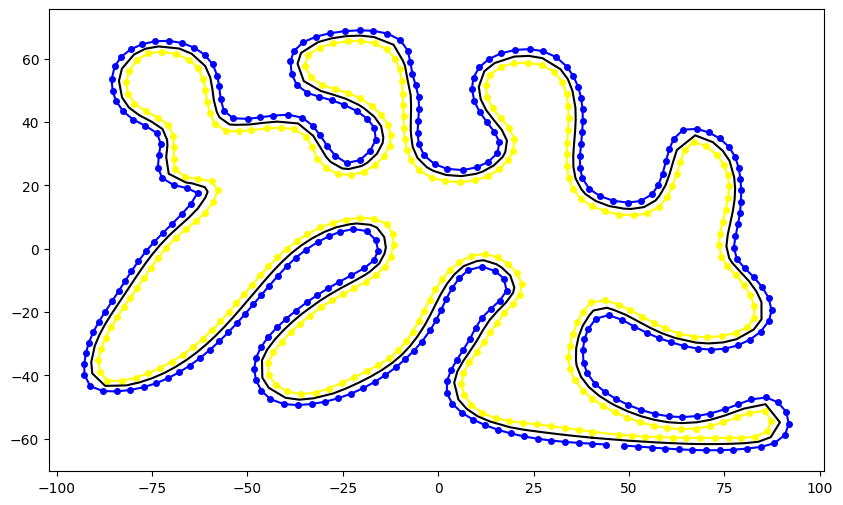

In [9]:
track = os.path.join(train_dir, "track (13).json")
x_blue, y_blue, x_yellow, y_yellow = readJsonFile(track)
x_path, y_path = generateMidpoints(x_blue, y_blue, x_yellow, y_yellow)
plotSamples(x_blue, y_blue, x_yellow, y_yellow, x_path, y_path)

In [10]:
def create_semicircle(center, direction, radius):

    # Calculate the starting and ending angles of the semicircle
    start_angle = direction - np.pi/2  # 90 degrees counter-clockwise from the direction
    end_angle = direction + np.pi/2    # 90 degrees clockwise from the direction

    # Generate angles from start_angle to end_angle
    angles = np.linspace(start_angle, end_angle, 100)

    # Calculate x and y coordinates of the semicircle points
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)
    return x, y



-51.71500889711194 -18.86856045931446


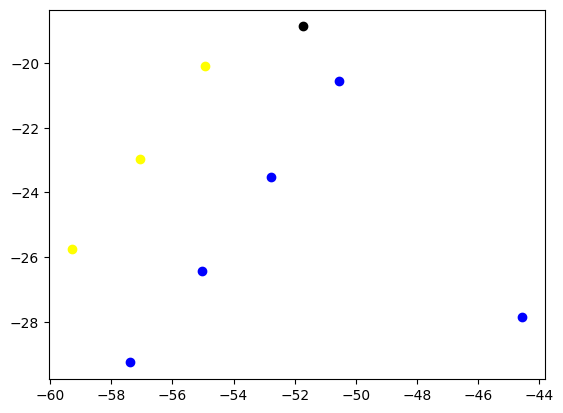

In [11]:
# get a random starting position
randIdx = random.randint(0, len(x_path)-1)
startX = x_path[randIdx]
startY = y_path[randIdx]
# startX = 60
# startY= -48
print(startX, startY)

radius = 12
startDir = math.atan2(y_path[randIdx+1] - startY, x_path[randIdx+1] - startX)
# startDir = 0
Maskx, Masky = create_semicircle([startX, startY], startDir, radius)


cones_blue = np.array(list(zip(x_blue, y_blue)))
cones_yellow = np.array(list(zip(x_yellow, y_yellow)))

def is_inside_semicircle(center, direction, radius, cones):
    # Calculate the starting and ending angles of the semicircle
    start_angle = direction - np.pi/2   # 90 degrees counter-clockwise from the direction
    end_angle = direction + np.pi/2   # 90 degrees clockwise from the direction

    # Prepare arrays to store results
    angle_within_range = np.zeros(len(cones), dtype=bool)
    distance_within_radius = np.zeros(len(cones), dtype=bool)

    # Iterate over each cone and check conditions
    for i, cone in enumerate(cones):
        # Calculate the vector from the center to the cone
        vector_to_cone = cone - center

        # Calculate the angle between the vector and the x-axis
        angle_to_cone = np.arctan2(vector_to_cone[1], vector_to_cone[0])

        # Check if the angle to the cone is within the range of the semicircle
        angle_within_range[i] = start_angle <= angle_to_cone <= end_angle
        # Check if the distance from the center to the cone is within the radius
        distance_within_radius[i] = np.linalg.norm(vector_to_cone) <= radius
        # if distance_within_radius[i]:
        #     print(angle_to_cone)

    # Return True for cones that satisfy both conditions
    # print(cones[angle_within_range==True])

    # plt.scatter(cones[distance_within_radius==True][:,0], cones[distance_within_radius==True][:,1])
    return angle_within_range & distance_within_radius
cones_blue = np.array(cones_blue)
cones_yellow = np.array(cones_yellow)
startPos = np.array([startX, startY])
coneBlueINSemiCircle = cones_blue[is_inside_semicircle(startPos, startDir, radius, cones_blue)]
conesYellowInSemiCircle = cones_yellow[is_inside_semicircle(startPos, startDir, radius, cones_yellow)]
# print(startPos)
plt.scatter(coneBlueINSemiCircle[:,0], coneBlueINSemiCircle[:,1], marker='o', c='blue', label='Blue Cones')
plt.scatter(conesYellowInSemiCircle[:,0], conesYellowInSemiCircle[:,1], marker='o', c='yellow', label='Yellow Cones')
plt.scatter(startPos[0], startPos[1], marker='o', c='black')

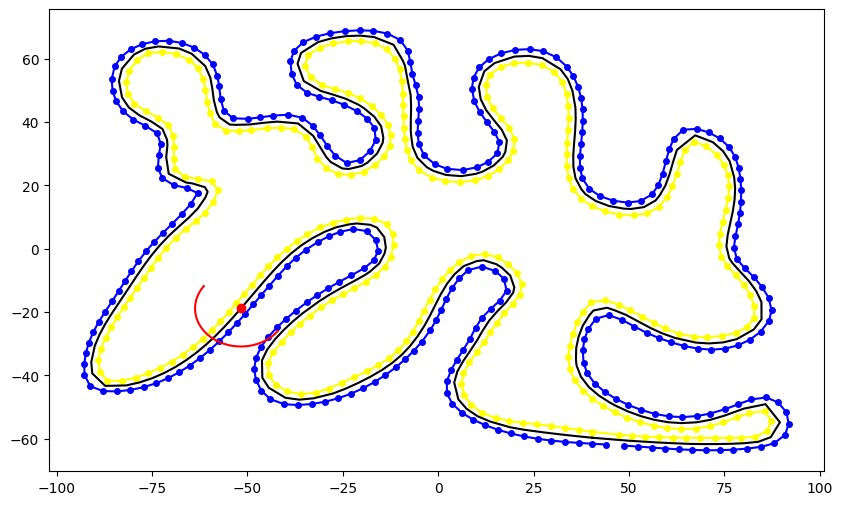

In [12]:
plotSamples(x_blue, y_blue, x_yellow, y_yellow, x_path, y_path)
plt.plot(startX, startY, marker = 'o', color = "red")
plt.plot(Maskx, Masky, color = "red")
plt.show()

In [13]:
conesInput = [np.zeros((0, 2)) for _ in ConeTypes]
conesInput[ConeTypes.BLUE] = np.vstack((conesInput[ConeTypes.BLUE], coneBlueINSemiCircle))
conesInput[ConeTypes.YELLOW] = np.vstack((conesInput[ConeTypes.YELLOW], conesYellowInSemiCircle))
pathplanner = PathPlanner()
path = pathplanner.calculatePathInGlobalFrame(vehiclePosition=startPos, vehicleDirection=startDir, cones=conesInput)
path


[6]
[0]
[6]
[0]


array([[-51.83087153, -19.03158147],
       [-52.28998378, -19.67756145],
       [-52.74909603, -20.32354144],
       [-53.29943344, -21.06441704],
       [-53.84977086, -21.80529265],
       [-54.40064051, -22.52737391],
       [-54.95151017, -23.24945518],
       [-55.50237982, -23.97153644],
       [-56.05324948, -24.69361771],
       [-56.62733585, -25.39618215],
       [-57.20142223, -26.09874659],
       [-57.7755086 , -26.80131103],
       [-58.34959498, -27.50387547],
       [-58.98234469, -28.27823185],
       [-59.6150944 , -29.05258823],
       [-60.24784411, -29.82694461],
       [-60.88059382, -30.60130099],
       [-61.51334353, -31.37565737],
       [-62.14609324, -32.15001375],
       [-62.77884295, -32.92437013],
       [-63.41159266, -33.69872651]])

(-64.35490942525108,
 -43.601940648163,
 -34.440234816380176,
 -18.127052156597045)

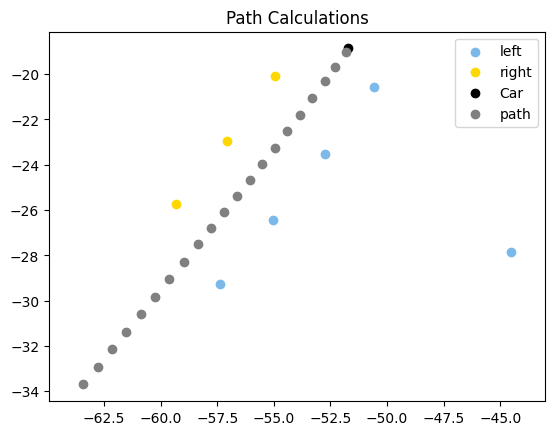

In [14]:
blue_color = "#7CB9E8"
yellow_color = "gold"

plt.scatter(coneBlueINSemiCircle[:, 0], coneBlueINSemiCircle[:, 1], c=blue_color, label="left")
plt.scatter(conesYellowInSemiCircle[:, 0], conesYellowInSemiCircle[:, 1], c=yellow_color, label="right")
# plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")
plt.scatter(startPos[0], startPos[1], c='black', label="Car")
plt.scatter(path[:,0], path[:,1], c='gray', label="path")
plt.legend()
plt.title("Path Calculations")
plt.axis("equal")

In [15]:
# import time

# first = True

# plt.show(block=False)
# fig = plt.figure()
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# for i in range(0,5):
#     pos = path[int(len(path)/2)]
#     dir = math.atan2(path[int(len(path)/2) + 1][1] - pos[1], path[int(len(path)/2) + 1][0] - pos[0])
#     coneBlueINSemiCircle = cones_blue[is_inside_semicircle(pos, dir, radius, cones_blue)]
#     conesYellowInSemiCircle = cones_yellow[is_inside_semicircle(pos, dir, radius, cones_yellow)]
#     conesInput = [np.zeros((0, 2)) for _ in ConeTypes]
#     conesInput[ConeTypes.BLUE] = np.vstack((conesInput[ConeTypes.BLUE], coneBlueINSemiCircle))
#     conesInput[ConeTypes.YELLOW] = np.vstack((conesInput[ConeTypes.YELLOW], conesYellowInSemiCircle))
#     path = pathplanner.calculatePathInGlobalFrame(vehiclePosition=pos, vehicleDirection=dir, cones=conesInput)
#     Maskx, Masky = create_semicircle(pos, dir, radius)
    
#     ax1.cla()
#     ax2.cla()

#     ax1.plot(x_blue, y_blue, marker='o', linestyle='-', color='blue', label='Blue Cones', markersize=1)
#     ax1.plot(x_yellow, y_yellow, marker='o', linestyle='-', color='yellow', label='Yellow Cones', markersize=1)
#     # ax1.plot(x_path, y_path, marker='', linestyle='-', color='black', label='Path')
#     ax1.plot(pos[0], pos[1], marker = 'o', color = "red")
#     ax1.plot(Maskx, Masky, color = "red")
#     ax1.scatter(path[:,0], path[:,1], c='black', label="path")

#     ax2.scatter(coneBlueINSemiCircle[:, 0], coneBlueINSemiCircle[:, 1], c=blue_color, label="left")
#     ax2.scatter(conesYellowInSemiCircle[:, 0], conesYellowInSemiCircle[:, 1], c=yellow_color, label="right")
#     # plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")
#     ax2.scatter(pos[0], pos[1], c='black', label="Car")
#     # print(pos)
#     # print(conesInput)
#     ax2.scatter(path[:,0], path[:,1], c='gray', label="path")

#     plt.pause(5)

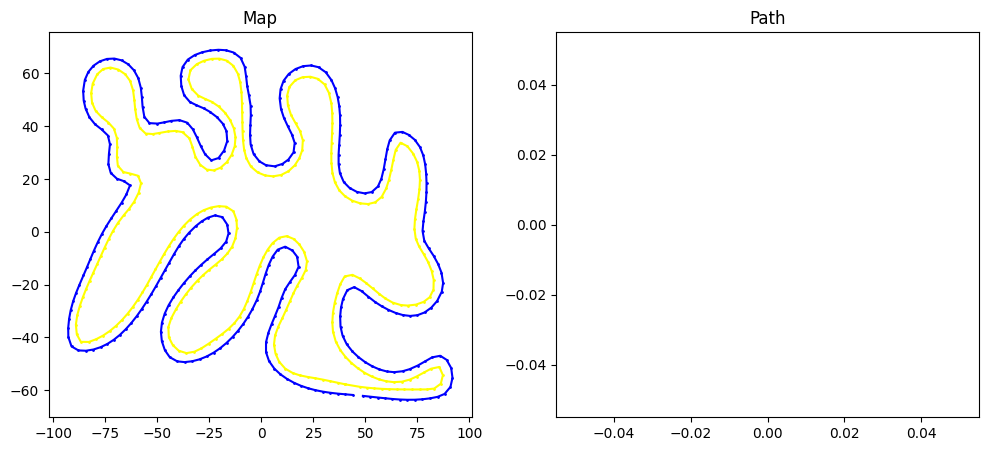

In [16]:
fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

ax1.set_title("Map")
ax2.set_title("Path")

ax1.plot(x_blue, y_blue, marker='o', linestyle='-', color='blue', label='Blue Cones', markersize=1)
ax1.plot(x_yellow, y_yellow, marker='o', linestyle='-', color='yellow', label='Yellow Cones', markersize=1)

pos1, = ax1.plot([], [], marker = 'o', color = "red") # Position
SC, = ax1.plot([], [], color = "red") #SemiCircle
path1, = ax1.plot([], [], c='black', label="path") #Path

left2, = ax2.plot([], [], c=blue_color, label="left") #Left, Blue
right2, = ax2.plot([], [], c=yellow_color, label="right") #Right, Yellow
pos2, = ax2.plot([], [], marker = 'o', color = "red") # Position
path2, = ax2.plot([], [], c='black', label="path") #Path

In [17]:

def updatePaths(path, radius):
    paths = []
    Maskxs = []
    Maskys = []
    poss = []
    blues = []
    yellows = []
    
    for n in range (500):
        pos = path[int(len(path)/4)]
        dir = math.atan2(path[int(len(path)/4) + 1][1] - pos[1], path[int(len(path)/4) + 1][0] - pos[0])
        coneBlueINSemiCircle = cones_blue[is_inside_semicircle(pos, dir, radius, cones_blue)]
        conesYellowInSemiCircle = cones_yellow[is_inside_semicircle(pos, dir, radius, cones_yellow)]
        conesInput = [np.zeros((0, 2)) for _ in ConeTypes]
        conesInput[ConeTypes.BLUE] = np.vstack((conesInput[ConeTypes.BLUE], coneBlueINSemiCircle))
        conesInput[ConeTypes.YELLOW] = np.vstack((conesInput[ConeTypes.YELLOW], conesYellowInSemiCircle))
        # if len(coneBlueINSemiCircle) < 3 and len(conesYellowInSemiCircle) < 3:
        #     path = path[:]
        # else:
        print(pos)
        path = pathplanner.calculatePathInGlobalFrame(vehiclePosition=pos, vehicleDirection=dir, cones=conesInput)
        Maskx, Masky = create_semicircle(pos, dir, radius)
        paths.append(path)
        Maskxs.append(Maskx)
        Maskys.append(Masky)
        poss.append(pos)
        blues.append(coneBlueINSemiCircle)
        yellows.append(conesYellowInSemiCircle)
    return paths, Maskxs, Maskys, poss, blues, yellows
       
paths, Maskxs, Maskys, poss, blues, yellows = updatePaths(path, radius)
path = paths[-1][:]
def drawframe(n):
    pos1.set_data(poss[n][0], poss[n][1])
    pos2.set_data(poss[n][0], poss[n][1])
    path1.set_data(paths[n][:,0], paths[n][:,1])
    path2.set_data(paths[n][:,0], paths[n][:,1])
    SC.set_data(Maskxs[n], Maskys[n])
    left2.set_data(blues[n][:,0], blues[n][:,1])
    right2.set_data(yellows[n][:,0], yellows[n][:,1])
    return pos1, pos2, path1, path2, SC, left2, right2

[-54.40064051 -22.52737391]
[5]
[0]
[5]
[0]
[-56.62733585 -25.39618215]
[5]
[0]
[5]
[0]
[-57.95066768 -27.01566996]
[5]
[0]
[5]
[0]
[-60.14880034 -29.5284313 ]
[6]
[0]
[6]
[0]
[-62.66996153 -32.12997717]
[8]
[0]
[8]
[0]
[-64.05601435 -33.84126491]
[5]
[0]
[-65.55391935 -35.26936396]
[8]
[0]
[8]
[0]
[-67.41920831 -36.51434815]
[5]
[0]
[-69.43229003 -38.2248375 ]
[5]
[0]
[-71.53412313 -39.56925845]
[5]
[0]
[-74.56031538 -41.11140537]
[3]
[0]
[-77.58130254 -42.27101667]
[0]
[0]
[-80.92293124 -43.12304659]
[0]
[0]
[-85.85324234 -43.52086529]
[6]
[0]
[-88.96719586 -40.97614639]
[8]
[0]
[7]
[0]
[-90.72093544 -38.48080788]
[6]
[0]
[6]
[0]
[-90.8089177  -34.94974726]
[8]
[0]
[8]
[0]
[-90.36868069 -32.26986376]
[7]
[0]
[7]
[0]
[-89.69233067 -29.80581371]
[7]
[0]
[7]
[0]
[-88.9918441  -27.80472038]
[8]
[0]
[10]
[0]
[-87.69773066 -24.76171495]
[10]
[0]
[-85.46124818 -20.92120108]
[8]
[0]
[8]
[0]
[-83.49903219 -16.7553837 ]
[7]
[0]
[7]
[0]
[-81.78572019 -13.65737631]
[7]
[0]
[7]
[0]
[-80.04955143 

In [19]:
from matplotlib import animation
anim = animation.FuncAnimation(fig, drawframe, frames=500, interval=100)

/home/mohd_yasser1/.local/lib/python3.10/site-packages/matplotlib/animation.py:880: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [20]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [35]:
anim.save("planning_hairpin.mp4")